In [1]:
# load the necessary functions
suppressMessages(library("rwwa"))

# Load extra covariate time series

## Nino3.4 time series

- Nino 3.4 time series can be downloaded from https://climexp.knmi.nl/data/iersst_nino3.4a_rel.dat  
  (copy & paste into a text file called nino34rel.txt)
- the data is monthly - we would usually use the December-February (DJF) mean to represent the preceding peak ENSO conditions

In [2]:
# load the data
nino <- read.table("nino34rel.txt", col.names = c("ym", "nino"))

# split the index into the year & month
nino$year <- as.integer(substr(nino$ym,1,4))
nino$month <- round((nino$ym - nino$year) * 12) + 1

# calculate the 3-month running mean
nino$nino34 <- filter(nino$nino, rep(1/3,3), sides = 1)

# select just the October-December values
nino_ond <- nino[nino$month == 12,c("year", "nino34")]

# select just the December-February values - data will be labelled as the year in which the period ends
nino_djf <- nino[nino$month == 2,c("year", "nino34")]

# if you want to match an event in eg. December 2024 with the Nino state from December 2024 to February 2025, you need to adjust the years:
nino_djf$year <- nino_djf$year - 1

## IOD time series

- IOD time series can be downloaded from https://climexp.knmi.nl/data/idmi_ersst.dat  
  (copy & paste into a text file called iod.txt)
- the data is monthly - you sould average over the calendar months that are relevant for your event
  - if you're looking at a whole season, average over those months
  - if you're looking at an event that lasted less than a month, choose the calendar month of the event

In [3]:
# load the data and label the columns correctly
iod <- read.table("iod.txt")
colnames(iod) <- c("year", paste0("m",1:12))

# select the months you want to include
months <- c(1,2)
iod <- data.frame("year" = iod$year, "iod" = rowMeans(iod[,paste0("m",months)]))

# Load the data

In [4]:
# load your annual time series & GMST
ts <- read.csv("rx30day-OND_chirps.csv", col.names = c("year", "x"))
gmst <- read.table("gmst.txt", col.names = c("year", "gmst"))

# merge time series with GMST covariate (matched by 'year' because this appears in both data.frames)
df <- merge(gmst, ts)

# also merge with Nino3.4 and IOD time series
df <- merge(nino_djf, merge(iod, df))

# adjust GMST to express as an anomaly with respect to your event year
ev_year <- 2023
df$gmst <- df$gmst - df$gmst[df$year == ev_year]

In [5]:
# the factual climate should reflect the year in which the event occurred
cov_factual <- df[df$year == ev_year,c("gmst", "iod", "nino34")]

# the counterfactual climate can represent any alternative climate (WWA always uses a preindustrial climate, 1.3C cooler than 2025)
# we're looking at three different counterfactuals: preindustrial, neutral IOD, neutral Nino
# we'll compare each of these to the factual climate
cov_counterfactual <- rbind("pi" = cov_factual - c(1.2, 0, 0),
                            "iod-neutral" = cov_factual - c(0, cov_factual$iod, 0),
                            "nino-neutral" = cov_factual - c(0, 0, cov_factual$nino34))

# Fit the chosen linear model & define the factual / counterfactual climates

In general,
- `type` is `shift` for temperatures and `fixeddisp` for precipitation
- `dist` is `GEV` for annual maxima/minima; `norm` for monthly/seasonal average

If this doesn't fit your data well, let us know - there are ways to transform skewed data to be more Gaussian, for example

In [6]:
# we're going to fit different versions of the model
mdl_gmst <- fit_ns(dist = "gev", type = "fixeddisp", data = df, varnm = "x", covnm = "gmst", lower = F, ev_year = ev_year)

In [7]:
mdl_gmst_iod <- fit_ns(dist = "gev", type = "fixeddisp", data = df, varnm = "x", covnm = c("gmst", "iod"), lower = F, ev_year = ev_year)

In [ ]:
mdl_gmst_nino <- fit_ns(dist = "gev", type = "fixeddisp", data = df, varnm = "x", covnm = c("gmst", "nino34"), lower = F, ev_year = ev_year)

In [10]:
boot_ci(mdl_gmst_nino, cov_f = cov_factual, cov_cf = cov_counterfactual[c(1,3),])

,est,2.5%,97.5%
mu0,102.61776570,77.9137473,1.412683e+02
sigma0,40.05030219,24.4115558,5.739745e+01
alpha_gmst,47.12551443,-5.5239190,1.414686e+02
alpha_nino34,21.06859590,4.9243574,4.022195e+01
shape,-0.01265906,-0.3587940,5.427598e-01
disp,0.39028624,0.2477144,4.559311e-01
event_magnitude,327.27200317,327.2720032,3.272720e+02
return_period,57.58962960,11.2706069,2.993691e+07
PR_pi,179.83433548,0.7544477,Inf
dI_abs_pi,138.65633291,-14.7898695,2.309025e+02


## Compare how well each model fits the data

- is there a strong relationship between the main variable and the covariate?
- was the covariate actually extreme at the time of the event?
- is the linear model a good fit?

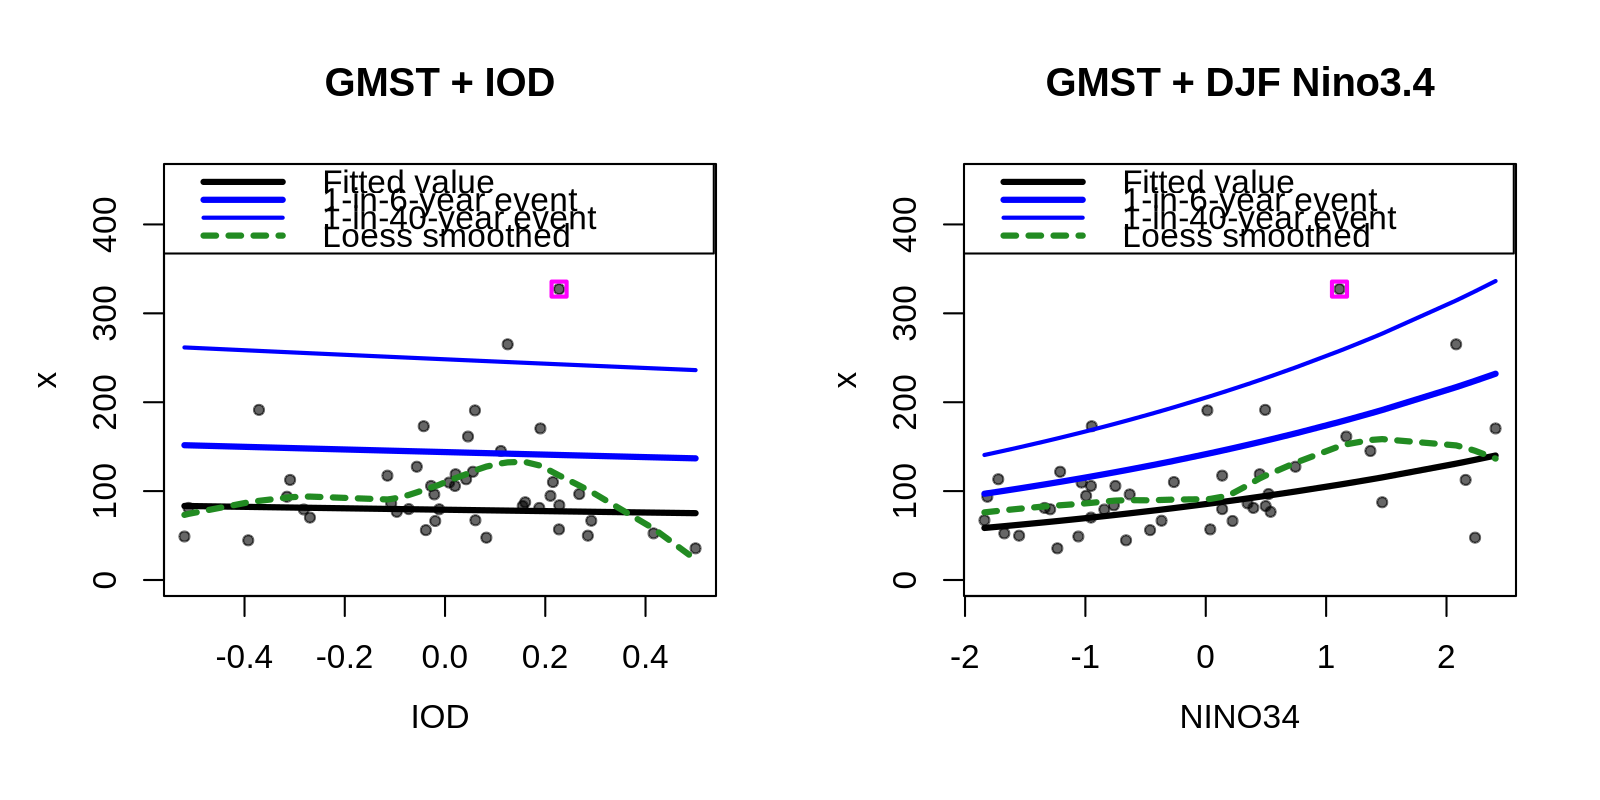

In [37]:
prep_window(c(1,2)) # function to plot two windows next to each other

ylim <- c(0,450) # change the y-axis limits for all plots

plot_covtrend(mdl_gmst_iod, xcov = "iod", main = "GMST + IOD", ylim = ylim)
plot_covtrend(mdl_gmst_nino, xcov = "nino34", main = "GMST + DJF Nino3.4", ylim = ylim)

- do the trends look different when we add the extra covariates? Do they seem to explain the extreme values better?

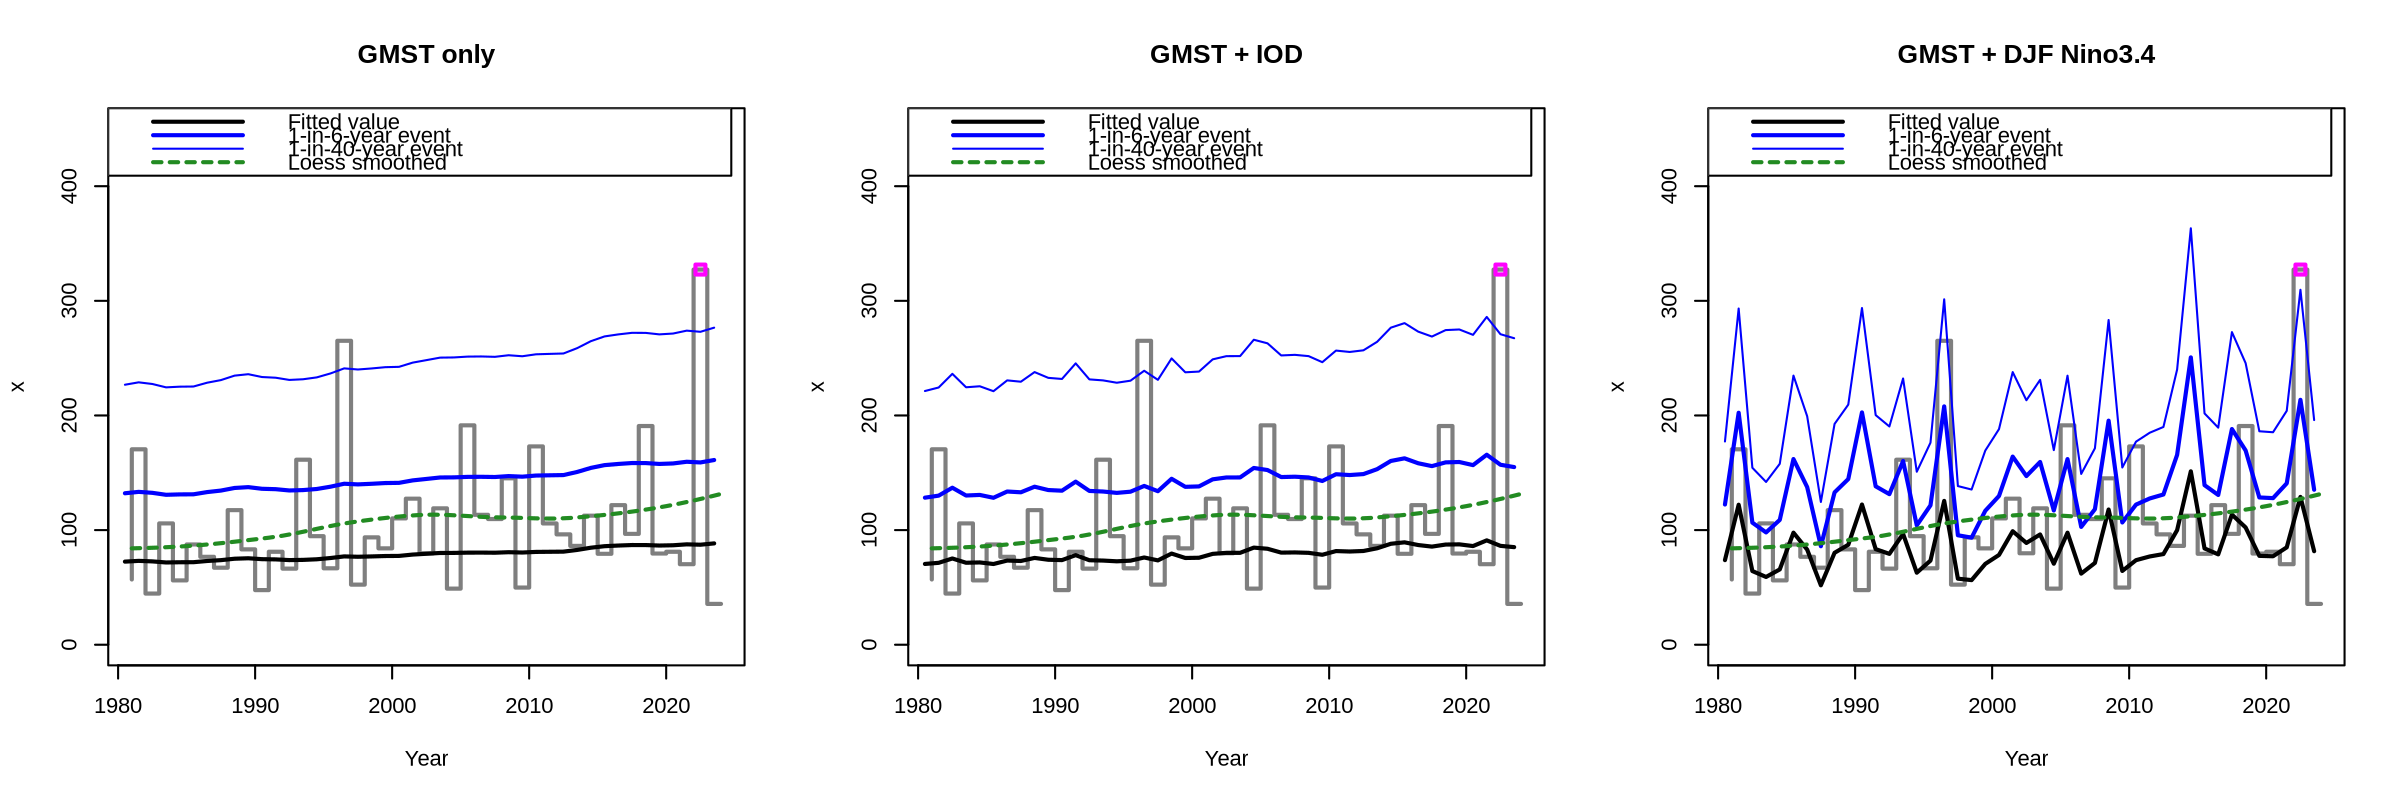

In [38]:
prep_window(c(1,3)) # function to plot three windows next to each other

plot_trend(mdl_gmst, main = "GMST only", ylim = ylim)
plot_trend(mdl_gmst_iod, main = "GMST + IOD", ylim = ylim)
plot_trend(mdl_gmst_nino, main = "GMST + DJF Nino3.4", ylim = ylim)

- the dependence on GMST should be about the same in all variants of the model

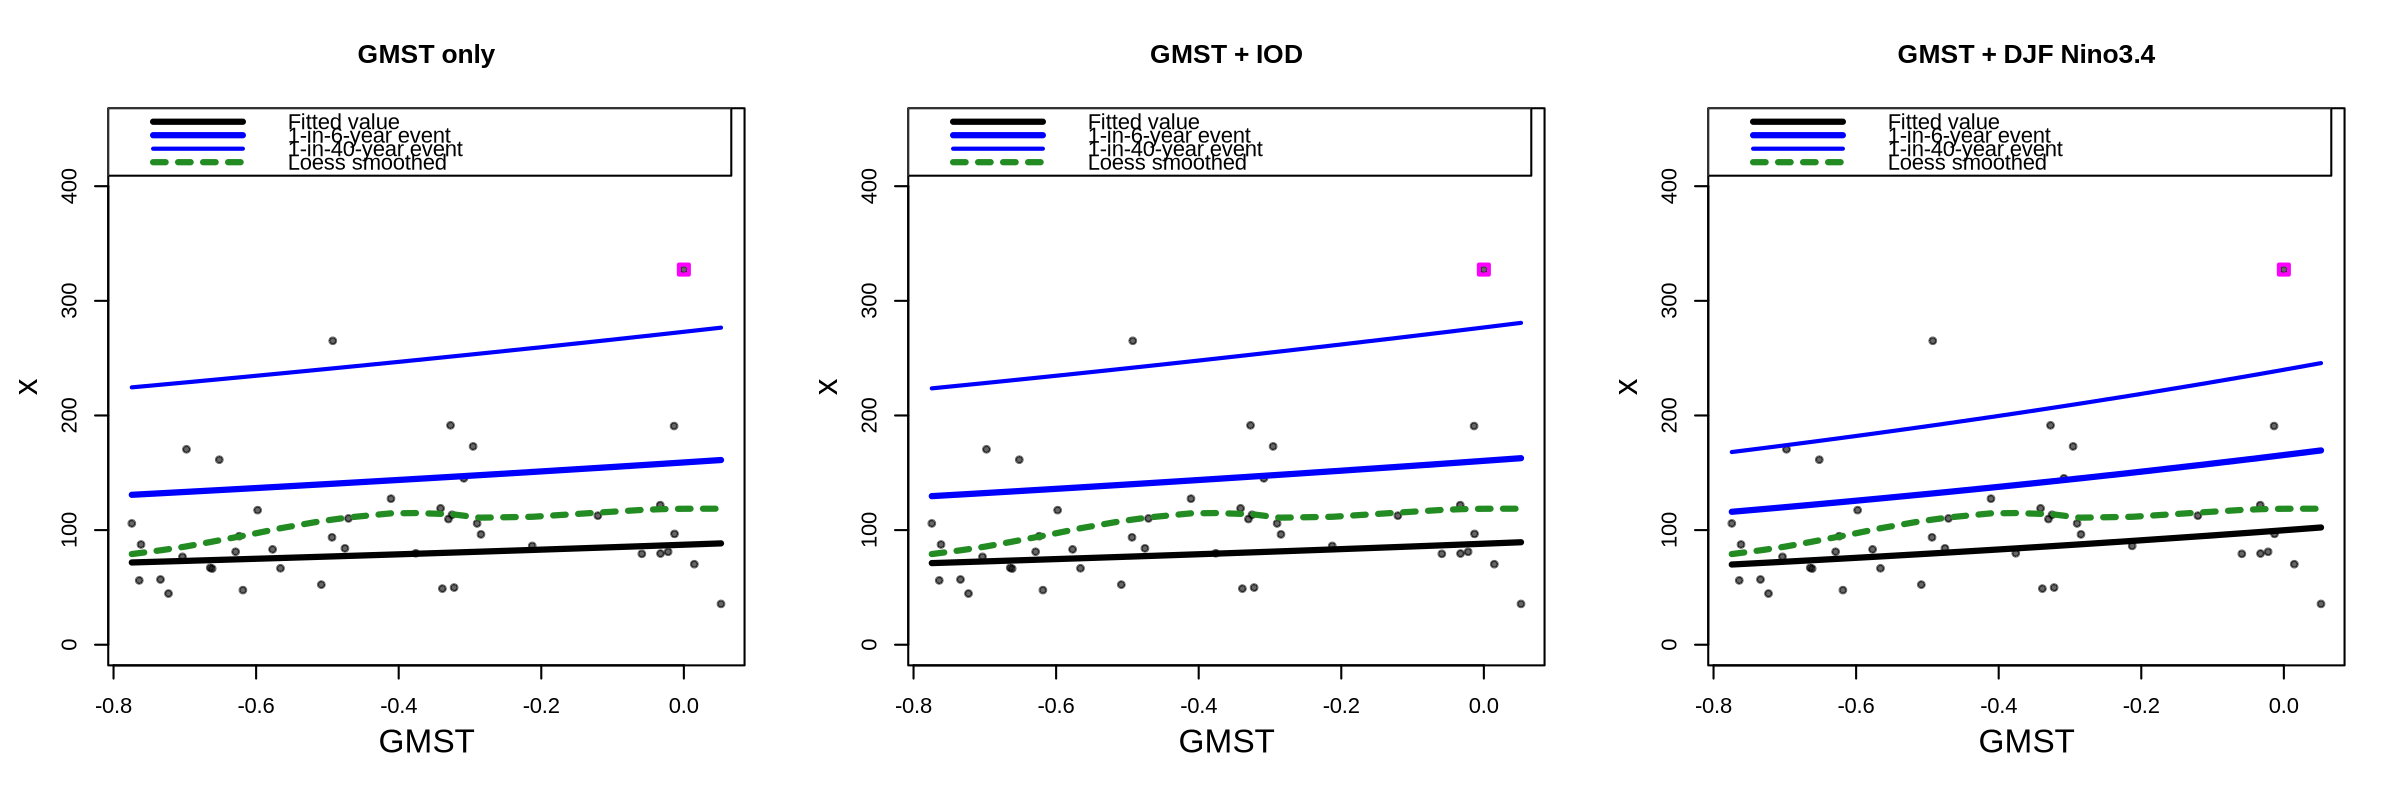

In [39]:
prep_window(c(1,3)) # function to plot three windows next to each other

plot_covtrend(mdl_gmst, xcov = "gmst", main = "GMST only", ylim = ylim)
plot_covtrend(mdl_gmst_iod, xcov = "gmst", main = "GMST + IOD", ylim = ylim)
plot_covtrend(mdl_gmst_nino, xcov = "gmst", main = "GMST + DJF Nino3.4", ylim = ylim)

- how much of a difference does it make when we remove the effect of each covariate?

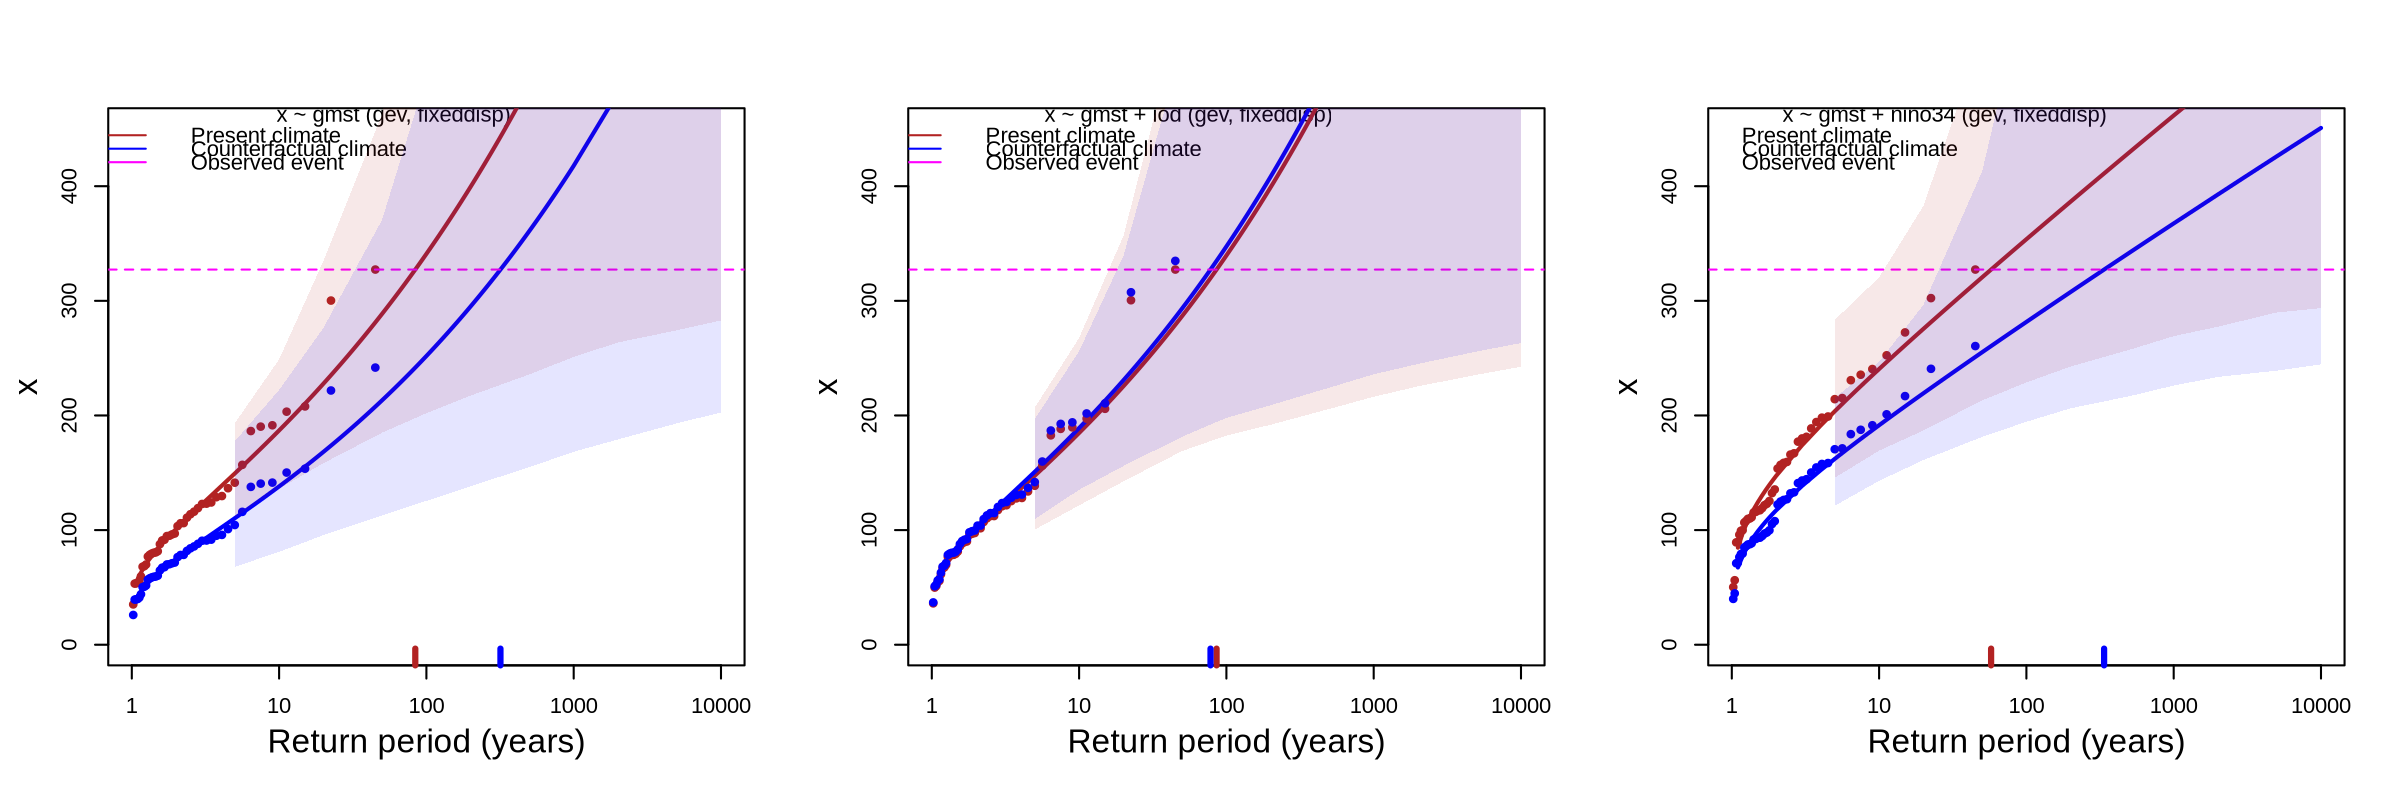

In [40]:
prep_window(c(1,3)) # function to plot three windows next to each other

plot_returnlevels(mdl_gmst, cov_f = cov_factual, cov_cf = cov_counterfactual["pi",,drop = F], ylim = ylim)
plot_returnlevels(mdl_gmst_iod, cov_f = cov_factual, cov_cf = cov_counterfactual["iod-neutral",,drop = F], ylim = ylim)
plot_returnlevels(mdl_gmst_nino, cov_f = cov_factual, cov_cf = cov_counterfactual["nino-neutral",,drop = F], ylim = ylim)

# Choose the model that fits the data best

- You can probably decide which model describes the data best based on the plots above.  
  If not, you can use the Akaike Information Criterion (AIC) to choose - lower scores are better
- You can only use the AIC to choose between models fitted to the same data

In [41]:
aic(mdl_gmst); aic(mdl_gmst_iod); aic(mdl_gmst_nino)

[1] 462.9258

[1] 464.7785

[1] 454.068

In [43]:
# choose the model you want to use
mdl <- mdl_gmst_nino

# Get the fitted model parameters \& results

The script will estimate both absolute and relative changes in intensity.
- For temperatures / `shift` fit, report **absolute** changes
- For precipitation / `fixeddisp` fit, report **relative** changes

In [44]:
# use the built-in function to bootstrap the model results
boot_res <- boot_ci(mdl, cov_f = cov_factual, cov_cf = cov_counterfactual)

In [45]:
# save as a .csv to look at them later
write.csv(boot_res, "res-obs_rx30day-chirps.csv")

# Produce some figures

You can modify the height and width of the figure by changing the height and width of the .png  
To see other plotting options, use eg. `?plot_trend`

In [ ]:
# comment out the top & bottom lines to see what the figures look like before saving them
png("fig_obs-trend_rx30day-chirps.png", height = 480, width = 480); {
    plot_trend(mdl, add_loess = T, ylim = c(18,33), ylab = "OND rainfall (mm)", lwd = 2)
}; dev.off()

In [ ]:
png("fig_obs-gmsttrend_rx30day-chirps.png", height = 480, width = 480); {
    plot_covtrend(mdl, xcov = "gmst", add_loess = T, ylim = c(18,33), ylab = "OND rainfall (mm)", lwd = 2)
}; dev.off()

In [ ]:
png("fig_obs-returnlevels_rx30day-chirps.png", height = 480, width = 480); {
    plot_returnlevels(mdl, cov_f = cov_factual, cov_cf = cov_counterfactual, ylim = c(18,33), ylab = "OND rainfall (mm)",
                     legend_labels = c("2023", "Preindustrial"))
}; dev.off()

In [ ]:
# you can create more plots here